In [1]:
import pandas as pd
import numpy as np
import h5py
import matplotlib.pyplot as plt
from PIL import Image
import datetime
from tqdm import tqdm

import torch
from torch import nn
import torch.nn.functional as func
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.optim as optim

from models import VGG
from train import train1Epoch
from train import test1Epoch
from datasetCreator import ImageSubset
torch.cuda.empty_cache()
import seaborn as sns

import os
import cv2

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#!del /Q /S /F runs\*
#!rmdir /S /Q runs

In [4]:
torch.cuda.is_available(), torch.version.cuda

(True, '11.1')

%load_ext tensorboard
torch.backends.cudnn.benchmark = True
writer=SummaryWriter()
%tensorboard --logdir='runs/' --inspect

!start chrome http://localhost:6006/

In [5]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

#pip install https://download.pytorch.org/whl/nightly/cu116/torch-1.14.0.dev20221023%2Bcu116-cp39-cp39-win_amd64.whl
#pip install https://download.pytorch.org/whl/nightly/cu116/torchvision-0.15.0.dev20221023%2Bcu116-cp39-cp39-win_amd64.whl
torch.cuda.is_available(), torch.version.cuda

In [6]:
DATA_PATH = '/home/ddavilag/teams/dsc-180a---a14-[88137]/df_bnpp_datapaths.csv'
KEY_PATH = '/home/ddavilag/teams/dsc-180a---a14-[88137]/df_bnpp_keys.csv'

In [7]:
os.listdir()

['models.py',
 'Week5_all data.ipynb',
 '.ipynb_checkpoints',
 'Week2_Task.ipynb',
 '.gitignore',
 'data',
 'runs',
 'Week2.ipynb',
 '.git',
 'Images',
 'Week3_Task.ipynb',
 'datasetCreator.py',
 'train.py',
 'README.md',
 '__pycache__',
 '.gitattributes']

In [8]:
df_datapaths = pd.read_csv(DATA_PATH, header=None).T.merge(pd.read_csv(KEY_PATH, header=None).T, left_index=True, right_index=True)
df_datapaths.columns = ['filepaths', 'key']
df_datapaths.key = df_datapaths.key.apply(lambda x: eval(x))
df_datapaths.filepaths = df_datapaths.filepaths.apply(lambda x: eval(x))
df_datapaths = df_datapaths.set_index('key')
#missing h5py files 7-9

In [9]:
cols= ['unique_key', 'bnpp_value_log', 'BNP_value' 
        #'BNPP_weight', 'PNA_mask', 'PNA_wight_mask', 'BNP_value', 'age_at_sampletime'
       ]
test_df = pd.read_csv('/home/ddavilag/teams/dsc-180a---a14-[88137]/BNPP_DT_test_with_ages.csv', usecols = cols).set_index('unique_key')
train_df = pd.read_csv('/home/ddavilag/teams/dsc-180a---a14-[88137]/BNPP_DT_train_with_ages.csv', usecols = cols).set_index('unique_key')
val_df = pd.read_csv('/home/ddavilag/teams/dsc-180a---a14-[88137]/BNPP_DT_val_with_ages.csv', usecols = cols).set_index('unique_key')
print(train_df.shape, test_df.shape, val_df.shape)
train_df['heart'] = train_df['BNP_value'].apply(lambda x: int(x > 400))
test_df['heart'] = test_df['BNP_value'].apply(lambda x: int(x > 400))
val_df['heart'] = val_df['BNP_value'].apply(lambda x: int(x > 400))


(21374, 2) (2602, 2) (2692, 2)


In [10]:
train_df = train_df.sort_index().merge(df_datapaths, left_index=True, right_index=True)
test_df = test_df.sort_index().merge(df_datapaths, left_index=True, right_index=True)
val_df = val_df.sort_index().merge(df_datapaths, left_index=True, right_index=True)
print(train_df.shape, test_df.shape, val_df.shape)

(15164, 4) (1823, 4) (1913, 4)


In [11]:
train_df['filepaths'] = train_df['filepaths'].str.replace('jmryan','ddavilag')
test_df['filepaths'] = test_df['filepaths'].str.replace('jmryan','ddavilag')
val_df['filepaths'] = val_df['filepaths'].str.replace('jmryan','ddavilag')
new_valid = pd.concat([test_df,val_df],ignore_index=False)
train_df.shape, test_df.shape, val_df.shape,new_valid.shape

((15164, 4), (1823, 4), (1913, 4), (3736, 4))

In [12]:
15164+1823+1913, 1823+1913
#number of rows that we currently have

(18900, 3736)

In [13]:
train_df.reset_index(names='unique_key',inplace=True)
new_valid.reset_index(names='unique_key',inplace=True)

In [14]:
train_df.head()

,unique_key,bnpp_value_log,BNP_value,heart,filepaths
0,Abachug_50267230_img1,2.621176,418.0,1,/home/ddavilag/teams/dsc-180a---a14-[88137]/bn...
1,Abafouck_52403307_img1,2.071882,118.0,0,/home/ddavilag/teams/dsc-180a---a14-[88137]/bn...
2,Abagash_52691625_img1,1.698101,49.9,0,/home/ddavilag/teams/dsc-180a---a14-[88137]/bn...
3,Abakleem_50725934_img1,4.301659,20029.0,1,/home/ddavilag/teams/dsc-180a---a14-[88137]/bn...
4,Abaphos_51936331_img1,3.219323,1657.0,1,/home/ddavilag/teams/dsc-180a---a14-[88137]/bn...


In [15]:
new_valid.head()

,unique_key,bnpp_value_log,BNP_value,heart,filepaths
0,Abadik_50217497_img1,3.334655,2161.0,1,/home/ddavilag/teams/dsc-180a---a14-[88137]/bn...
1,Abdisey_52768446_img1,2.451786,283.0,0,/home/ddavilag/teams/dsc-180a---a14-[88137]/bn...
2,Abenog_51901728_img1,2.647383,444.0,1,/home/ddavilag/teams/dsc-180a---a14-[88137]/bn...
3,Abeyned_51238065_img1,2.869232,740.0,1,/home/ddavilag/teams/dsc-180a---a14-[88137]/bn...
4,Abibey_51056225_img1,2.710117,513.0,1,/home/ddavilag/teams/dsc-180a---a14-[88137]/bn...


In [16]:
#from zmq import device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class PreprocessedImageDataset(Dataset):
    def __init__(self, df, transform=None, target_transform=None):
        self.df = df.to_numpy()
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        #row = self.df.loc[idx,:]
        row = self.df[idx,:]
        #filepath = row[4]  #image location
        #val = row[1] #bnpp value log
        #heart = row[3] #threshold for edema
        
        #im = torch.load(filepath)
        #print(filepath, val, heart)
        #plt.imshow(im,cmap='gray')
        #plt.show()
        #returns image, bnpp value log, binary variable for edema
        #return torch.load(row[4]).view(1, 224, 224).expand(3, -1, -1), row[1], row[3]
        return torch.load(row[4]).view(1, 224, 224), row[1], row[3]

In [17]:
batch_size = 32 #maybe change to 16, 8
num_workers = 4
pin_memory = True
# train_transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=(0.5), std=(0.5))
#     ])

train_set = PreprocessedImageDataset(df=train_df) #, transform = train_transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)

# valid_transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=(0.5), std=(0.5))
#     ])

valid_set = PreprocessedImageDataset(df=new_valid) #, transform = valid_transform)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)

#print(train_set[0])
#print(iter(train_loader).next())
#print(train.__getitem__(0))
#len(valid_set)

import time
pin_memory = True
print('pin_memory is', pin_memory)
 
for num_workers in range(0, 5): 
    #train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    #sampler=train_sampler, num_workers=num_workers, pin_memory=pin_memory)
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
    start = time.time()
    for epoch in range(1, 3):
        for i, data in enumerate(train_loader):
            pass
    end = time.time()
    print("Finish with:{} second, num_workers={}".format(end - start, num_workers))

In [18]:
train_set[0], valid_set[0]

((tensor([[[0.3960, 0.3263, 0.2679,  ..., 0.6759, 0.6131, 0.5799],
           [0.3731, 0.2965, 0.2382,  ..., 0.5817, 0.5546, 0.5515],
           [0.3515, 0.2655, 0.2093,  ..., 0.4992, 0.4945, 0.5271],
           ...,
           [0.2838, 0.2328, 0.1758,  ..., 0.0935, 0.1776, 0.3074],
           [0.4374, 0.3808, 0.3173,  ..., 0.0947, 0.1776, 0.3110],
           [0.6096, 0.5594, 0.5006,  ..., 0.0964, 0.1787, 0.3197]]]),
  2.621176281775035,
  1),
 (tensor([[[0.7653, 0.7322, 0.6512,  ..., 0.0091, 0.0098, 0.0191],
           [0.7650, 0.7331, 0.6562,  ..., 0.0126, 0.0145, 0.0153],
           [0.7687, 0.7393, 0.6639,  ..., 0.0037, 0.0043, 0.0042],
           ...,
           [0.6958, 0.7201, 0.7454,  ..., 0.4772, 0.4948, 0.5551],
           [0.7046, 0.7250, 0.7456,  ..., 0.4813, 0.4856, 0.5497],
           [0.7090, 0.7267, 0.7453,  ..., 0.4876, 0.4873, 0.5444]]]),
  3.334654766883241,
  1))

In [19]:
len(train_loader), len(train_set), len(valid_loader),len(valid_set)

(474, 15164, 117, 3736)

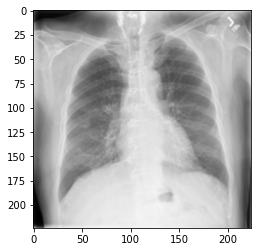

In [20]:
plt.imshow(train_set[0][0].permute(1, 2, 0),cmap='gray')

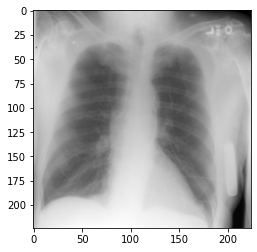

In [21]:
plt.imshow(valid_set[0][0].permute(1, 2, 0),cmap='gray')

In [22]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
model = VGG('VGG16').to(device)
model

cuda


VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.01)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slope=0.01)
    (13): MaxP

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys_r")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(train_loader)
images, labels, _ = dataiter.next()

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid)
print('  '.join(str('%.2f' % labels[j].item()) for j in range(batch_size)))

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"[INFO]: Computation device: {device}")

total_params = sum(p.numel() for p in model.parameters())
print(f"[INFO]: {total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"[INFO]: {total_trainable_params:,} trainable parameters.")

# the loss function, Mean Absolute Error
loss_fn = nn.L1Loss().to(device)
#loss_fn = nn.HuberLoss().to(device)
#loss_fn = nn.SmoothL1Loss().to(device)
#roc_auc = ROC_AUC()

# the optimizer
# need to tune optimizer
#optimizer = optim.Adam(model.parameters(), lr=0.0001)
LR = 0.0001
RHO = 0.99
#optimizer = optim.Adadelta(model.parameters(), lr=LR, rho=RHO)
optimizer = optim.Adam(model.parameters(), lr=0.0001, amsgrad=True)


[INFO]: Computation device: cuda
[INFO]: 27,513,261 total parameters.
[INFO]: 27,513,261 trainable parameters.


In [24]:

# Initializing in a separate cell so we can easily add more epochs to the same run
#timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
epoch_number = 0

EPOCHS = 10
#best_vloss = 1_000_000.

# the scheduler
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

tlosses, vlosses=[],[]
# writer.add_text('model params', \
#                 f'''VGG16\n
#                 loss: {'MAE'}\n
#                 optimizer: {'Adam'}\n
#                 \tlearn rate: {LR}\n
#                 \trho: {RHO}\n
#                 batch size: {batch_size}\n
#                 nodes: {500}\n
#                 dropout: {0}\n
#                 batchnorm: {'yes'}\n
#                 RELU: {'Leaky'}\n
#                 epochs: {EPOCHS}
#                 ''',\
#                 0)

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    #model.train(True)
    for param in model.parameters():
        param.requires_grad = True
    
    avg_tloss = train1Epoch(epoch_number, model, optimizer, loss_fn, train_loader)#, writer)
    
    #print(torch.cuda.memory_summary())
    # We don't need gradients on to do reporting
    for param in model.parameters():
        param.requires_grad = False
        
    #model.train(False)
    with torch.no_grad():
        avg_vloss = test1Epoch(epoch_number, model, loss_fn, valid_loader)

    #print(torch.cuda.memory_summary())
    print('LOSS train {} valid {}'.format(avg_tloss, avg_vloss))
    #writer.add_scalars('Loss', {'train':avg_tloss,'test':avg_vloss}, epoch)
    tlosses.append(avg_tloss)
    vlosses.append(avg_vloss)

    # Track best performance, and save the model's state
#     if avg_vloss < best_vloss:
#         best_vloss = avg_vloss
#         model_path = 'model_{}_{}'.format(timestamp, epoch_number)
#         torch.save(model.state_dict(), model_path)

    epoch_number += 1
    #scheduler.step(avg_vloss)
#writer.flush()
#writer.close()

EPOCH 1:


  0%|          | 0/474 [00:00<?, ?it/s]/opt/conda/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████| 474/474 [01:29<00:00,  5.30it/s]
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
100%|██████████| 117/117 [00:06<00:00, 16.89it/s]

LOSS train 0.6388508766135083 valid 0.6212926328691661
EPOCH 2:



[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
100%|██████████| 474/474 [01:30<00:00,  5.22it/s]
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
100%|██████████| 117/117 [00:06<00:00, 16.90it/s]

LOSS train 0.5663101907017865 valid 0.5378586792538309
EPOCH 3:



[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
100%|██████████| 474/474 [01:31<00:00,  5.20it/s]
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
100%|██████████| 117/117 [00:06<00:00, 16.89it/s]

LOSS train 0.5461473903827023 valid 0.5338902190709726
EPOCH 4:



[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
100%|██████████| 474/474 [01:30<00:00,  5.21it/s]
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
100%|██████████| 117/117 [00:06<00:00, 16.96it/s]

LOSS train 0.5284794396740474 valid 0.5298567528908069
EPOCH 5:



[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
100%|██████████| 474/474 [01:31<00:00,  5.21it/s]
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
100%|██████████| 117/117 [00:06<00:00, 16.90it/s]

LOSS train 0.5197133417496701 valid 0.49274781244432825
EPOCH 6:



[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
100%|██████████| 474/474 [01:30<00:00,  5.21it/s]
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
100%|██████████| 117/117 [00:06<00:00, 16.90it/s]

LOSS train 0.5046813767167586 valid 0.5673723495923556
EPOCH 7:



[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
100%|██████████| 474/474 [01:30<00:00,  5.21it/s]
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
100%|██████████| 117/117 [00:06<00:00, 16.78it/s]

LOSS train 0.4949617392780409 valid 0.5321821020199702
EPOCH 8:



[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
100%|██████████| 474/474 [01:31<00:00,  5.21it/s]
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
100%|██████████| 117/117 [00:06<00:00, 16.81it/s]

LOSS train 0.490199538159974 valid 0.4850034968465821
EPOCH 9:



[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
100%|██████████| 474/474 [01:31<00:00,  5.20it/s]
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
100%|██████████| 117/117 [00:06<00:00, 16.88it/s]

LOSS train 0.47796603653752856 valid 0.4923430645567739
EPOCH 10:



[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
100%|██████████| 474/474 [01:31<00:00,  5.19it/s]
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
100%|██████████| 117/117 [00:06<00:00, 16.74it/s]

LOSS train 0.46812409552340767 valid 0.4855210483074188


/opt/conda/lib/python3.9/site-packages/seaborn/axisgrid.py:676: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/opt/conda/lib/python3.9/site-packages/seaborn/axisgrid.py:676: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]


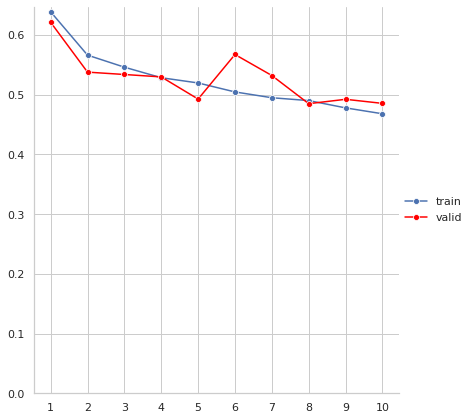

In [25]:
epochs = np.arange(1,EPOCHS+1)
df = pd.DataFrame(data={'train loss': tlosses,'valid loss':vlosses})
#display(df)
sns.set(style='whitegrid')
#plt.figure(figsize=(20,3))

g = sns.FacetGrid(df, height = 6)

g = g.map(sns.lineplot, x=epochs,y=tlosses,marker='o', label='train')
g = g.map(sns.lineplot, x=epochs,y=vlosses,color='red',marker='o', label='valid')
g.set(ylim=(0, None))
g.add_legend()
plt.xticks(epochs)
plt.show()

In [26]:
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
preds, hearts = np.array([]), np.array([])
valid_loader = DataLoader(valid_set, batch_size=1, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)
with torch.no_grad():
        for i, (image, _, heart) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
            image = image.to(device, non_blocking=True)
            pred = model(image)
            hearts = np.append(hearts, heart)
            preds = np.append(preds, pred.item())

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
100%|██████████| 3736/3736 [00:15<00:00, 234.29it/s]


In [27]:
preds = 10**preds
y_preds = preds > 400

In [28]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve


print(f'accuracy score: {accuracy_score(hearts, y_preds)}')
cf_mat = confusion_matrix(hearts, y_preds)
print('Confusion matrix')
print(cf_mat)

accuracy score: 0.7858672376873662
Confusion matrix
[[1049  374]
 [ 426 1887]]


In [29]:
def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """

    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

model 1 AUC score: 0.7764992940691785


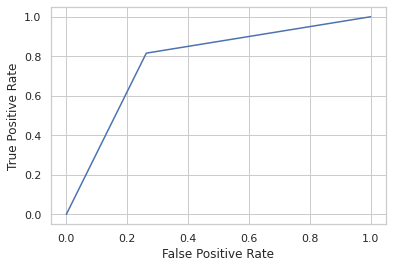

In [30]:
plot_roc_curve(hearts, y_preds)
print(f'model 1 AUC score: {roc_auc_score(hearts, y_preds)}')

In [ ]:
torch.save(model, '/home/ddavilag/private/DSC180A/DSC180A')

In [33]:
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_fn
            }, '/home/ddavilag/private/DSC180A/DSC180A/VGG16_1.pt')

#Loading the model
model = TheModelClass(*args, **kwargs)
optimizer = TheOptimizerClass(*args, **kwargs)

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.eval()
# - or -
model.train()